**Настраиваю тетрадку для работы**

In [1]:
# Импортирую sklearn чтобы перед установкой ядра  была свежая версия библиотеки
#!pip install --upgrade scikit-learn -q
# Устанавливаю библиотеки, которых нет
# Устанавливаю ядро 3.7 для корректной работы библиотеки ydata_profiling
#!python -m ipykernel install --user --name py37env --display-name "Python 3.7"
# Устанавливаю версию matplotlib==3.7.3 для корректной работы библиотеки ydata_profiling
#!pip install matplotlib==3.7.3 -q
#%matplotlib inline
# Обновляю numba
# !pip install --upgrade numba
!pip install --upgrade ydata_profiling visions numba -q
# Устанавливию библиотеку ydata_profiling
try:
    import ydata_profiling
except ModuleNotFoundError:
    !pip install ydata_profiling -q
    
# Импортиую нужные для работы библиотеки
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from nltk.stem import SnowballStemmer
import numpy as np
import pandas as pd
#import plotly.graph_objects as go
from phik import phik_matrix, resources, report
from phik.report import plot_correlation_matrix
from scipy.stats import randint, uniform
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, f_regression
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score, 
    roc_auc_score, 
    mean_squared_error, 
    r2_score,
    mean_absolute_error,
    make_scorer
)
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    StratifiedKFold,  
    KFold,
    ParameterSampler,
    ParameterGrid,
    RandomizedSearchCV
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MultiLabelBinarizer,
    OneHotEncoder,
    FunctionTransformer,
    PolynomialFeatures,
    LabelEncoder
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
import time
from ydata_profiling import ProfileReport
from ydata_profiling.config import Settings
# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [2]:
# Устанавливаю формат отображения для чисел в DataFrame
pd.set_option('display.float_format', '{:,.2f}'.format)
# Устанавливаю тему по умолчанию для диаграмм Seaborn
sns.set_theme(style="ticks")
RANDOM_STATE = 42  

# Разработка модели машинного обучения для предсказания судьбы стартапов

В этом проекте я должен разработать модель машинного обучения, которая поможет определить судьбу стартапа. 



Для достижения этой цели мне предстоит проанализировать псевдо-реальные (реальные данные в которые добавлена синтетическая составляющая) даннын о стартапах, функционировавших в период с 1970 по 2018 годы, построить прогнозную модель для прогоза их закрытия.



Данные о стартапах находятся в файлах: 

- `kaggle_startups_test_28062024.csv`

- `kaggle_startups_train_28062024.csv`

<br><br>



В датасетах содержатся следующие признаки:

- `name` - Название стартапа

- `category_list` - Список категорий, к которым относится стартап

- `funding_total_usd` - Общая сумма финансирования в USD

- `status` - Статус стартапа (закрыт или действующий)

- `country_code` - Код страны

- `state_code` - Код штата

- `region` - Регион

- `city` - Город

- `funding_rounds` - Количество раундов финансирования

- `founded_at` - Дата основания

- `first_funding_at` - Дата первого раунда финансирования

- `last_funding_at` - Дата последнего раунда финансирования

- `closed_at` - Дата закрытия стартапа (если применимо)

- `lifetime` - Время существования стартапа в днях

- `status` - Целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу `operating`, `closed`.

<br><br>



Условия задачи:

- это задача классификации
- нужно потратить время на предобработку и дообогащение данных

## Загрузка и подготовка данных

### Загрузка данных

In [3]:
startups_test = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-39-ds/kaggle_startups_test_28062024.csv')
startups_train = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-39-ds/kaggle_startups_train_28062024.csv')

In [4]:
startups_test.sample(1)

name category_list  funding_total_usd country_code  \
11489  Grassroots Unwired    CRM|Mobile         700,000.00          USA   

      state_code        region          city  funding_rounds first_funding_at  \
11489         PA  Philadelphia  Philadelphia               3       2011-12-07   

      last_funding_at  lifetime  
11489      2014-06-18      3287

In [5]:
startups_train.sample(1)

name                    category_list  funding_total_usd  \
17902  Stem Disintermedia  Accounting|Creative|Music|Video                NaN   

       status country_code state_code region city  funding_rounds  founded_at  \
17902  closed          NaN        NaN    NaN  NaN               1  2015-02-13   

      first_funding_at last_funding_at   closed_at  
17902       2015-10-13      2015-10-13  2017-01-03

**Вывод по шагу 1.1:**

1. Загружены массивы - `startups_test`,  `startups_train`.

### Предобработка данных

#### Вывожу общую информацию о массивах

In [6]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [7]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


#### Перевожу названия стартапов в индексы

In [8]:
startups_train = startups_train.set_index('name')
startups_test = startups_test.set_index('name')

#### Задаю правильные типы столбцов

##### Устанавливаю тип дата и оставляю только месяц и год

In [9]:
# Список названий колонок с датой
date_columns = ['first_funding_at', 'last_funding_at']
# Функция для смены типа на дату и извлечения лет и месяцев
def transform_dates(df, date_columns):
    # Проходим по каждому столбцу с датой
    for col in date_columns:
        # Преобразуем столбец в тип datetime
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Создаем новые столбцы с годом и месяцем
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
    
    # Удаляем исходные столбцы с датами
    df = df.drop(columns=date_columns)
    
    return df

In [10]:
# Применяю функцию к тренировочной выборке
startups_train_transformed = transform_dates(startups_train, date_columns)
# Проверка
startups_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   category_list           50051 non-null  object 
 1   funding_total_usd       42447 non-null  float64
 2   status                  52516 non-null  object 
 3   country_code            47014 non-null  object 
 4   state_code              45753 non-null  object 
 5   region                  46157 non-null  object 
 6   city                    46157 non-null  object 
 7   funding_rounds          52516 non-null  int64  
 8   founded_at              52516 non-null  object 
 9   closed_at               4917 non-null   object 
 10  first_funding_at_year   52516 non-null  int32  
 11  first_funding_at_month  52516 non-null  int32  
 12  last_funding_at_year    52516 non-null  int32  
 13  last_funding_at_month   52516 non-null  int32  
dtypes: float64(1), int32(4), int64

In [11]:
# Применяю функцию к тренировочной выборке
startups_test_transformed = transform_dates(startups_test, date_columns)
# Проверка
startups_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   category_list           12534 non-null  object 
 1   funding_total_usd       10547 non-null  float64
 2   country_code            11743 non-null  object 
 3   state_code              11430 non-null  object 
 4   region                  11536 non-null  object 
 5   city                    11538 non-null  object 
 6   funding_rounds          13125 non-null  int64  
 7   lifetime                13125 non-null  int64  
 8   first_funding_at_year   13125 non-null  int32  
 9   first_funding_at_month  13125 non-null  int32  
 10  last_funding_at_year    13125 non-null  int32  
 11  last_funding_at_month   13125 non-null  int32  
dtypes: float64(1), int32(4), int64(2), object(5)
memory usage: 1.1+ MB


Все ок

##### Создаю в тренировочной выборке столбец с продолжительностью жизни стартапа

In [12]:
# Функция для расчета жизни стартапа
def calculate_lifetime(df):
    # Преобразуем столбцы с датами в формат datetime
    df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
    df['closed_at'] = pd.to_datetime(df['closed_at'], errors='coerce')

    # Устанавливаем дату по умолчанию, если 'closed_at' пропущен (2018-01-01)
    default_date = pd.to_datetime('2018-01-01')
    
    # Если 'closed_at' пропущен, используем default_date
    df['closed_at'] = df['closed_at'].fillna(default_date)

    # Рассчитываем продолжительность жизни стартапа в днях
    df['lifetime'] = (df['closed_at'] - df['founded_at']).dt.days

    # Удаляем столбец founded_at
    df = df.drop(columns=['founded_at', 'closed_at'])
    
    return df

In [13]:
# Применение функции
startups_train_transformed = calculate_lifetime(startups_train_transformed)

In [14]:
startups_train_transformed.sample(2)

category_list  \
name                                                                                                                                              
Verato  Big Data|Big Data Analytics|Cloud Data Services|Data Privacy|Health Care Information Technology|Information Services|Personal Data|SaaS   
BigRep                                                                                                                            Manufacturing   

        funding_total_usd     status country_code state_code  \
name                                                           
Verato      12,500,000.00  operating          USA         VA   
BigRep       9,647,963.80  operating          NaN        NaN   

                  region    city  funding_rounds  first_funding_at_year  \
name                                                                      
Verato  Washington, D.C.  Mclean               1                   2015   
BigRep               NaN     NaN               3                   2013   

        first_funding_at_month  last_funding_at_year  last_funding_at_month  \
name                                                                          
Verato                       1                  2015                      1   
BigRep                      12                  2015                     11   

        lifetime  
name              
Verato      2161  
BigRep      1461

#### Очистка и приведение к единому виду текстовых значений

In [15]:
# Функция для очистки текста
def clean_text(text):
    if isinstance(text, str):  # Проверка, что это строка
        # Убираем лишние пробелы, приводим к нижнему регистру и удаляем пробелы в начале/конце
        return ' '.join(text.split()).strip().lower()
    return text  # Возвращаем как есть, если это не строка (например, NaN)

In [16]:
# Список текстовых столбцов
text_columns = ['category_list', 'status', 'country_code', 'state_code', 'region', 'city']
# Функция для для очистки текстовых значений во всех текстовых колонках массива
def df_text_clean(df):
    for column in text_columns:
        if column in df.columns:
            # Применим очистку к каждому элементу в текстовых столбцах
            df[column] = df[column].fillna("unknown").apply(clean_text)

In [17]:
df_text_clean(startups_train_transformed)
startups_train_transformed.sample(3)

category_list  \
name                                                                                       
Integral Development Corp.                                           enterprise software   
SmartAll                                              home automation|internet of things   
OnGreen                     angels|clean technology|entrepreneur|finance|venture capital   

                            funding_total_usd     status country_code  \
name                                                                    
Integral Development Corp.      11,000,000.00  operating          sgp   
SmartAll                           600,000.00  operating          usa   
OnGreen                          1,400,000.00  operating          usa   

                           state_code       region           city  \
name                                                                
Integral Development Corp.    unknown    singapore      singapore   
SmartAll                           ca  sf bay area  san francisco   
OnGreen                            ca  los angeles    los angeles   

                            funding_rounds  first_funding_at_year  \
name                                                                
Integral Development Corp.               1                   2009   
SmartAll                                 2                   2015   
OnGreen                                  1                   2010   

                            first_funding_at_month  last_funding_at_year  \
name                                                                       
Integral Development Corp.                       6                  2009   
SmartAll                                         4                  2015   
OnGreen                                         11                  2010   

                            last_funding_at_month  lifetime  
name                                                         
Integral Development Corp.                      6      9131  
SmartAll                                       10      1006  
OnGreen                                        11      3035

In [18]:
df_text_clean(startups_test_transformed)
startups_test_transformed.sample(3)

category_list  \
name                                                                  
SegmentFault                                     curated web|mobile   
Goloo                           fitness|healthcare services|medical   
Fortscale     analytics|big data|machine learning|security|software   

              funding_total_usd country_code state_code       region  \
name                                                                   
SegmentFault         164,744.00          chn    unknown      unknown   
Goloo                459,272.00          dnk         17  dnk - other   
Fortscale         16,000,000.00          usa         ca  sf bay area   

                        city  funding_rounds  lifetime  first_funding_at_year  \
name                                                                            
SegmentFault         unknown               2      1858                   2014   
Goloo         charlottenlund               1      2238                   2013   
Fortscale      san francisco               3      2192                   2013   

              first_funding_at_month  last_funding_at_year  \
name                                                         
SegmentFault                       1                  2014   
Goloo                              5                  2013   
Fortscale                          2                  2015   

              last_funding_at_month  
name                                 
SegmentFault                      9  
Goloo                             5  
Fortscale                        11

#### Укрупнение категорий стартапов

In [19]:
def cat_consolidation(original_df, category_mapping):
    # Шаг 0: Создаем копию исходного массива
    df = original_df.copy()    
    
    # Преобразуем его в словарь, где ключом является 'Initial', а значением — 'Final'
    mapping = {row['Initial']: row['Final'] for _, row in category_mapping.iterrows()}
    
    # Шаг 2: Разделить категории по символу |, обработав пропуски
    df['categories_split'] = df['category_list'].fillna('unknown').str.lower().str.split('|')  # Приводим к нижнему регистру
    
    # Шаг 3: Удалить дубликаты категорий для каждого стартапа и применить маппинг
    df['mapped_categories'] = df['categories_split'].apply(
        lambda categories: list(set([mapping.get(cat.strip(), cat) for cat in categories])) if isinstance(categories, list) else []
    )
    
    # Шаг 4: Создать бинарные признаки для категорий
    mlb = MultiLabelBinarizer()
    binary_categories = pd.DataFrame(mlb.fit_transform(df['mapped_categories']), columns=mlb.classes_, index=df.index)
    
    # Шаг 5: Проверяем наличие дубликатов колонок и избегаем их
    columns_to_add = [col for col in binary_categories.columns if col not in df.columns]
    
    # Соединяем бинарные признаки с оригинальными данными
    df = df.join(binary_categories[columns_to_add])
    
    # Шаг 6: Добавляем укрупненные категории, которых не было в исходных данных, с нулями
    all_final_categories = set(mapping.values())
    missing_categories = all_final_categories - set(binary_categories.columns)
    
    # Добавляем пропущенные категории с нулями
    for category in missing_categories:
        df[category] = 0
    
    # Шаг 7: Удаляем ненужные промежуточные столбцы для чистоты
    df = df.drop(columns=['category_list', 'categories_split', 'mapped_categories'])
    
    # Возвращаем изменённый DataFrame
    return df

In [20]:
filepath = '/kaggle/input/categories-rework-claude-new-new/categories_rework_claude_new.xlsx'

In [21]:
category_mapping = pd.read_excel(filepath)

In [22]:
startups_train_cons = cat_consolidation(startups_train_transformed, category_mapping)

In [23]:
startups_test_cons = cat_consolidation(startups_test_transformed, category_mapping)

In [24]:
startups_train_cons.shape

(52516, 49)

In [25]:
startups_test_cons.shape

(13125, 48)

In [26]:
startups_train_cons.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   funding_total_usd           42447 non-null  float64
 1   status                      52516 non-null  object 
 2   country_code                52516 non-null  object 
 3   state_code                  52516 non-null  object 
 4   region                      52516 non-null  object 
 5   city                        52516 non-null  object 
 6   funding_rounds              52516 non-null  int64  
 7   first_funding_at_year       52516 non-null  int32  
 8   first_funding_at_month      52516 non-null  int32  
 9   last_funding_at_year        52516 non-null  int32  
 10  last_funding_at_month       52516 non-null  int32  
 11  lifetime                    52516 non-null  int64  
 12  Adult                       52516 non-null  int64  
 13  Agriculture & Food     

In [27]:
startups_test_cons.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   funding_total_usd           10547 non-null  float64
 1   country_code                13125 non-null  object 
 2   state_code                  13125 non-null  object 
 3   region                      13125 non-null  object 
 4   city                        13125 non-null  object 
 5   funding_rounds              13125 non-null  int64  
 6   lifetime                    13125 non-null  int64  
 7   first_funding_at_year       13125 non-null  int32  
 8   first_funding_at_month      13125 non-null  int32  
 9   last_funding_at_year        13125 non-null  int32  
 10  last_funding_at_month       13125 non-null  int32  
 11  Adult                       13125 non-null  int64  
 12  Agriculture & Food          13125 non-null  int64  
 13  Arts & Culture       

In [28]:
startups_train_cons.sample(3)

funding_total_usd     status country_code state_code  \
name                                                                        
Qnect, llc                1,306,000.00  operating          usa         ma   
Causata                  15,500,000.00  operating          usa         ca   
uReach Technologies       5,000,000.00  operating          usa         nj   

                          region           city  funding_rounds  \
name                                                              
Qnect, llc            ma - other         hadley               3   
Causata              sf bay area  san francisco               2   
uReach Technologies       newark        holmdel               1   

                     first_funding_at_year  first_funding_at_month  \
name                                                                 
Qnect, llc                            2014                       5   
Causata                               2009                      10   
uReach Technologies                   2004                      11   

                     last_funding_at_year  ...  Professional Services  \
name                                       ...                          
Qnect, llc                           2015  ...                      0   
Causata                              2011  ...                      0   
uReach Technologies                  2004  ...                      0   

                     Real Estate  Recreation  Retail  Social Media  \
name                                                                 
Qnect, llc                     0           0       0             0   
Causata                        0           0       0             0   
uReach Technologies            0           0       0             0   

                     Technology  Telecommunications  Transportation  \
name                                                                  
Qnect, llc                    1                   0               0   
Causata                       1                   0               0   
uReach Technologies           1                   0               0   

                     Travel & Hospitality  Unknown  
name                                                
Qnect, llc                              0        0  
Causata                                 0        0  
uReach Technologies                     0        0  

[3 rows x 49 columns]

In [29]:
startups_test_cons.sample(3)

funding_total_usd country_code state_code  \
name                                                                  
Afferent Pharmaceuticals      89,200,000.00          usa         ca   
Transit App                      477,269.00          can         qc   
Playmaroo                        448,436.00      unknown    unknown   

                               region       city  funding_rounds  lifetime  \
name                                                                         
Afferent Pharmaceuticals  sf bay area  san mateo               7      3287   
Transit App                  montreal   montréal               2      1722   
Playmaroo                     unknown    unknown               1      2008   

                          first_funding_at_year  first_funding_at_month  \
name                                                                      
Afferent Pharmaceuticals                   2003                       8   
Transit App                                2013                       4   
Playmaroo                                  2013                       8   

                          last_funding_at_year  ...  Real Estate  Recreation  \
name                                            ...                            
Afferent Pharmaceuticals                  2015  ...            0           0   
Transit App                               2014  ...            0           0   
Playmaroo                                 2013  ...            0           0   

                          Retail  Social Media  Technology  \
name                                                         
Afferent Pharmaceuticals       0             0           0   
Transit App                    0             0           1   
Playmaroo                      0             0           0   

                          Telecommunications  Transportation  \
name                                                           
Afferent Pharmaceuticals                   0               0   
Transit App                                0               1   
Playmaroo                                  0               0   

                          Travel & Hospitality  Unknown  Geography  
name                                                                
Afferent Pharmaceuticals                     0        0          0  
Transit App                                  1        0          0  
Playmaroo                                    0        0          0  

[3 rows x 48 columns]

Количество категорий уменьшено до 38. Каждая категория теперь бинарный признак.

#### Чищу другие категориальные столбцы

In [30]:
startups_train_cons.columns

Index(['funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'first_funding_at_year',
       'first_funding_at_month', 'last_funding_at_year',
       'last_funding_at_month', 'lifetime', 'Adult', 'Agriculture & Food',
       'Arts & Culture', 'Business Models', 'Business Services',
       'Construction', 'Consumer Goods', 'Demographics', 'E-commerce',
       'Education', 'Energy & Utilities', 'Entertainment',
       'Environmental Services', 'Events', 'Finance', 'Food & Beverage',
       'Geography', 'Government', 'Health & Wellness',
       'Healthcare & Life Sciences', 'Human Resources', 'Industrial', 'Legal',
       'Manufacturing', 'Marketing', 'Media & Entertainment', 'Non-Profit',
       'Professional Services', 'Real Estate', 'Recreation', 'Retail',
       'Social Media', 'Technology', 'Telecommunications', 'Transportation',
       'Travel & Hospitality', 'Unknown'],
      dtype='object')

In [31]:
startups_train_cons['country_code'].unique()

array(['che', 'usa', 'unknown', 'gbr', 'rus', 'esp', 'fra', 'swe', 'ind',
       'kor', 'aus', 'twn', 'chn', 'hun', 'can', 'fin', 'bra', 'egy',
       'prt', 'isr', 'chl', 'svk', 'nld', 'arg', 'are', 'jpn', 'irl',
       'deu', 'lbn', 'est', 'idn', 'bel', 'mex', 'dnk', 'ita', 'grc',
       'rom', 'tur', 'sgp', 'sau', 'mys', 'nga', 'qat', 'vnm', 'bgr',
       'gha', 'uga', 'jor', 'aut', 'pak', 'nzl', 'hkg', 'zaf', 'lva',
       'nor', 'hrv', 'ven', 'per', 'lux', 'svn', 'pol', 'phl', 'nic',
       'cze', 'isl', 'pan', 'ury', 'bgd', 'mco', 'gtm', 'tha', 'tto',
       'ukr', 'ken', 'cri', 'dza', 'ltu', 'cym', 'mus', 'blr', 'slv',
       'col', 'mlt', 'pse', 'blz', 'cyp', 'mmr', 'mkd', 'khm', 'gib',
       'srb', 'dom', 'bwa', 'blm', 'pry', 'bmu', 'tan', 'lie', 'grd',
       'uzb', 'geo', 'sen', 'alb', 'ecu', 'moz', 'lka', 'lao', 'tun',
       'hnd', 'zwe', 'bah', 'mda', 'maf', 'bhr', 'aze', 'mar', 'kwt',
       'irn', 'ggy', 'kna', 'pri', 'omn', 'kaz', 'jam', 'npl', 'arm',
       'tgo', 'r

In [32]:
startups_train_cons['status'].unique()

array(['operating', 'closed'], dtype=object)

In [33]:
startups_train_cons['state_code'].unique()

array(['25', 'ca', 'unknown', 'va', 'nj', 'tx', 'or', 'fl', 'wa', 'ny',
       'c7', 'az', '91', 'ga', 'ma', 'pa', 'mi', '56', 'mn', 'a8', 'de',
       '26', 'q5', '7', 'ri', '11', 'c5', 'co', '3', '23', '1', 'on',
       'il', 'oh', 'k2', '2', '14', '30', 'h9', 'al', '29', '6', 'nc',
       '5', '12', '22', 'md', '48', 'nd', '40', 'k4', 'vt', '16', '4',
       'ut', 'in', '8', '9', '18', 'ct', '13', 'nv', '10', 'b8', '27',
       '17', 'ia', 'wi', 'l9', 'nm', 'b7', 'mo', 'bc', '21', 'f7', 'me',
       'nh', '35', 'ns', 'c1', 'c3', 'sc', '20', 'tn', 'a6', '51', 'i7',
       'la', 'ks', '42', 'n7', 'u8', 'i2', 'ar', '19', 'ne', '41', 'qc',
       'ab', '37', '15', '97', 'v2', 'd2', 'dc', 'a7', 'c9', 'f8', 'y2',
       'b9', 'j7', 'm9', 'g2', 'h3', 'id', 'nb', '28', 'v8', '34', 'b5',
       'f2', 'a9', 'z7', '53', 'h8', 'mt', 'mb', 'ky', '61', '60', 'b4',
       'h7', '82', 'a2', 'c8', 'l3', 'b3', 'd9', 'm3', 'ms', '31', '33',
       '52', 'hi', 'ak', '78', '72', 'q4', 'y4', 'wy', '32', 

In [34]:
startups_train_cons['city'].unique()

array(['zürich', 'redwood city', 'san jose', ..., 'circleville',
       'doncaster', 'centreville'], dtype=object)

### Задаю тип category для категориальных столбцов

In [35]:
# Функция для перевода столбцов в тип category
def to_category(df):
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist() # Создаем список текстовых столбцов
#     # Убираем имена стартапов и целевой признак
#     for category in categorical_columns:
#         if category in ['status']:
#             categorical_columns.remove(category) 
    # Переводим клонки в тип category
    for column in categorical_columns:
        category_names = df[column].unique() # Создаем перечень категорий в колонке
        df[column] = pd.Categorical(df[column], categories=category_names, ordered=False)
    # Вывод результата
    df.info()
    # Возвращаем изменённый DataFrame
    return df

In [36]:
startups_train_cons_cat = to_category(startups_train_cons)

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   funding_total_usd           42447 non-null  float64 
 1   status                      52516 non-null  category
 2   country_code                52516 non-null  category
 3   state_code                  52516 non-null  category
 4   region                      52516 non-null  category
 5   city                        52516 non-null  category
 6   funding_rounds              52516 non-null  int64   
 7   first_funding_at_year       52516 non-null  int32   
 8   first_funding_at_month      52516 non-null  int32   
 9   last_funding_at_year        52516 non-null  int32   
 10  last_funding_at_month       52516 non-null  int32   
 11  lifetime                    52516 non-null  int64   
 12  Adult                       52516 non-null  int64   
 13  Agricult

In [37]:
startups_test_cons_cat = to_category(startups_test_cons)

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   funding_total_usd           10547 non-null  float64 
 1   country_code                13125 non-null  category
 2   state_code                  13125 non-null  category
 3   region                      13125 non-null  category
 4   city                        13125 non-null  category
 5   funding_rounds              13125 non-null  int64   
 6   lifetime                    13125 non-null  int64   
 7   first_funding_at_year       13125 non-null  int32   
 8   first_funding_at_month      13125 non-null  int32   
 9   last_funding_at_year        13125 non-null  int32   
 10  last_funding_at_month       13125 non-null  int32   
 11  Adult                       13125 non-null  int64   
 12  Agriculture & Food          13125 non-null  int64   
 13  Arts &

#### Меняю типы данных для снижения размеров массивов

In [38]:
# Вывожу стат дыннае для чиловых параметров, чтобы определиться с разрядностью
startups_test_cons_cat.describe()

funding_total_usd  funding_rounds  lifetime  first_funding_at_year  \
count          10,547.00       13,125.00 13,125.00              13,125.00   
mean       16,549,102.70            1.71  3,097.61               2,011.09   
std        92,172,825.63            1.32  2,128.36                   3.64   
min                 1.00            1.00     52.00               1,973.00   
25%           320,000.00            1.00  1,726.00               2,009.00   
50%         2,000,000.00            1.00  2,526.00               2,012.00   
75%        10,000,000.00            2.00  3,866.00               2,014.00   
max     4,715,000,000.00           15.00 17,167.00               2,015.00   

       first_funding_at_month  last_funding_at_year  last_funding_at_month  \
count               13,125.00             13,125.00              13,125.00   
mean                     6.23              2,011.98                   6.34   
std                      3.57                  3.39                   3.49   
min                      1.00              1,973.00                   1.00   
25%                      3.00              2,011.00                   3.00   
50%                      6.00              2,013.00                   6.00   
75%                      9.00              2,014.00                   9.00   
max                     12.00              2,015.00                  12.00   

          Adult  Agriculture & Food  Arts & Culture  ...  Real Estate  \
count 13,125.00           13,125.00       13,125.00  ...    13,125.00   
mean       0.00                0.01            0.02  ...         0.02   
std        0.01                0.09            0.15  ...         0.13   
min        0.00                0.00            0.00  ...         0.00   
25%        0.00                0.00            0.00  ...         0.00   
50%        0.00                0.00            0.00  ...         0.00   
75%        0.00                0.00            0.00  ...         0.00   
max        1.00                1.00            1.00  ...         1.00   

       Recreation    Retail  Social Media  Technology  Telecommunications  \
count   13,125.00 13,125.00     13,125.00   13,125.00           13,125.00   
mean         0.02      0.04          0.07        0.46                0.01   
std          0.12      0.19          0.26        0.50                0.10   
min          0.00      0.00          0.00        0.00                0.00   
25%          0.00      0.00          0.00        0.00                0.00   
50%          0.00      0.00          0.00        0.00                0.00   
75%          0.00      0.00          0.00        1.00                0.00   
max          1.00      1.00          1.00        1.00                1.00   

       Transportation  Travel & Hospitality   Unknown  Geography  
count       13,125.00             13,125.00 13,125.00  13,125.00  
mean             0.03                  0.03      0.05       0.00  
std              0.16                  0.18      0.21       0.00  
min              0.00                  0.00      0.00       0.00  
25%              0.00                  0.00      0.00       0.00  
50%              0.00                  0.00      0.00       0.00  
75%              0.00                  0.00      0.00       0.00  
max              1.00                  1.00      1.00       0.00  

[8 rows x 44 columns]

In [39]:
# Меняю типы данных
for col in ['funding_rounds', 'first_funding_at_month', 'last_funding_at_month']:
    startups_train_cons_cat[col] = startups_train_cons_cat[col].astype('int8')
    startups_test_cons_cat[col] = startups_test_cons_cat[col].astype('int8')
for col in ['first_funding_at_year', 'last_funding_at_year', 'lifetime']:
    startups_train_cons_cat[col] = startups_train_cons_cat[col].astype('int16')
    startups_test_cons_cat[col] = startups_test_cons_cat[col].astype('int16')
for col in [startups_train_cons_cat.columns[12:]]:
    startups_train_cons_cat[col] = startups_train_cons_cat[col].astype('bool')
    startups_test_cons_cat[col] = startups_test_cons_cat[col].astype('bool')

#### Работаю с дубликатами

In [40]:
def obv_duplicates(data, array_name):
    """
    Создаю функцию, которая проверяет массив на наличие явных дубликатов.
    Parameters:
    data (DataFrame): Входной DataFrame для обработки.
    array_name : Имя массива.
    Returns:
    None
    """
    for col in data.columns:   
        # Проверяю есть ли явные дубликаты строк
        obvious_duplicates_qty = data.duplicated(keep='first').sum()
    if obvious_duplicates_qty != 0:
        print(f"В массиве '{array_name}' количество явных дубликатов строк = {obvious_duplicates_qty}.")
        display(data[data.duplicated()])
    else:
        print(f"Явные дубликаты строк в массиве '{array_name}' отсутствуют.")

In [41]:
# Создаю словарик с массивами и их именами
data= {
    'startups_train_cons':startups_train_cons_cat,
    'startups_test_cons':startups_test_cons_cat
}

In [42]:
# Применяю функцию к массивам
for key, value in data.items():
    obv_duplicates(value, key)

В массиве 'startups_train_cons' количество явных дубликатов строк = 37.


funding_total_usd     status country_code state_code  \
name                                                                          
theCre8tion                          NaN  operating          kor         11   
America's Real Deal           670,000.00  operating          usa         ut   
Go World!                      50,000.00  operating          sgp    unknown   
Kerros Health                        NaN  operating      unknown    unknown   
BODUB                                NaN  operating      unknown    unknown   
Refract                              NaN  operating      unknown    unknown   
Two to Tango                         NaN  operating      unknown    unknown   
Youtopia                             NaN  operating          usa         il   
AppHarbor                            NaN  operating          usa         ca   
Tappur                        100,000.00  operating          usa         ca   
FiftyFiver                           NaN  operating          usa         ny   
MetaPop Inc.                         NaN  operating      unknown    unknown   
Sembrowser Ltd.                      NaN  operating      unknown    unknown   
textmetix                            NaN  operating      unknown    unknown   
Car in the Cloud               50,000.00  operating          sgp    unknown   
Train Station Brewery                NaN  operating      unknown    unknown   
Two4one                              NaN  operating      unknown    unknown   
Get-n-Post                           NaN  operating      unknown    unknown   
Retechnica                           NaN  operating      unknown    unknown   
Eve Snow                             NaN  operating      unknown    unknown   
Kashable                             NaN  operating      unknown    unknown   
PacketViper                          NaN  operating      unknown    unknown   
LEDeXCHANGE GmbH                     NaN  operating      unknown    unknown   
ecash express                        NaN  operating      unknown    unknown   
Prześwietl.pl                        NaN  operating      unknown    unknown   
Plisten                              NaN  operating      unknown    unknown   
PandoMedia                           NaN  operating      unknown    unknown   
Barnpengar                           NaN  operating      unknown    unknown   
Reflectum                            NaN  operating      unknown    unknown   
InterStelNet                         NaN  operating          usa         ca   
Tabacus Initative              40,000.00  operating          chl         12   
SOPATec                              NaN  operating      unknown    unknown   
Voicegem                             NaN  operating          usa         ca   
Sendoid                              NaN  operating          usa         ca   
Case Commons                         NaN  operating          usa         ny   
Logan                          25,000.00  operating          arg          7   
On-the-Go Academy               7,515.51  operating          bra         27   

                               region           city  funding_rounds  \
name                                                                   
theCre8tion                     seoul          seoul               1   
America's Real Deal    salt lake city      bountiful               1   
Go World!                   singapore      singapore               1   
Kerros Health                 unknown        unknown               1   
BODUB                         unknown        unknown               1   
Refract                       unknown        unknown               1   
Two to Tango                  unknown        unknown               1   
Youtopia                      chicago        chicago               1   
AppHarbor                 sf bay area  san francisco               1   
Tappur                    sf bay area  san francisco               1   
FiftyFiver              new york city       new york               1   
MetaP

В массиве 'startups_test_cons' количество явных дубликатов строк = 2.


funding_total_usd country_code state_code    region  \
name                                                                      
Zikk Software Ltd.                NaN          isr          5  tel aviv   
Continuum Care                    NaN      unknown    unknown   unknown   

                        city  funding_rounds  lifetime  first_funding_at_year  \
name                                                                            
Zikk Software Ltd.  tel aviv               1      1826                   2014   
Continuum Care       unknown               1      1077                   2011   

                    first_funding_at_month  last_funding_at_year  ...  \
name                                                              ...   
Zikk Software Ltd.                       1                  2014  ...   
Continuum Care                           1                  2011  ...   

                    Real Estate  Recreation  Retail  Social Media  Technology  \
name                                                                            
Zikk Software Ltd.        False       False   False         False        True   
Continuum Care            False       False   False         False       False   

                    Telecommunications  Transportation  Travel & Hospitality  \
name                                                                           
Zikk Software Ltd.               False           False                 False   
Continuum Care                   False           False                 False   

                    Unknown  Geography  
name                                    
Zikk Software Ltd.    False      False  
Continuum Care         True      False  

[2 rows x 48 columns]

**Вывод по шагу 1.2:**
1. В массивах `startups_train_cons`, `startups_train_cons` явные дубликаты отсуствуют.

### Исследовательский анализ данных

#### Исследую массивы по отдельности

In [43]:
# Создаю функцию для профилирования данных в массиве с помощью ydata-profiling

def data_profiling(df, report_title, sample_size=None):
    # Если задан sample_size, берём подвыборку данных
    if sample_size and sample_size < len(df):
        df = df.sample(n=sample_size, random_state=42)        
    data_profile=ProfileReport(
        df, 
        duplicates=None, 
        samples=None,
        title=report_title,
        progress_bar = False,
        explorative=True,
        missing_diagrams= None,
        vars={
            "cat":{"lenght": False, "characters": False, "words": True, "histogram_largest":0},
            "num":{"low_categorical_threshold":0}
        },
        correlations={
            "auto": {"calculate": False},
            "pearson": {"calculate": False},
            "spearman": {"calculate": False},
            "kendall": {"calculate": False},
            "phi_k": {"calculate": True, "warn_high_correlations": True},
            "cramers": {"calculate": False},
        },
        plot={
            "missing": {"force_labels": True},
            "scatter_threshold": 5000,
            "cat_freq": {"show": True, "type": "pie", "max_unique": 50}
        },

        interactions={
            "continuous": False
        }   
    )
    return data_profile

In [44]:
# Вывожу отчеты по массивам

reports=[]
for key, value in data.items():
    data_profile = data_profiling(value, key)
    reports.append(data_profile)
    display(data_profile)

#### Сравниваю массивы

In [45]:
def plot_pie_chart_top_10(df, category_columns):
    # Подсчет количества True значений в каждой колонке
    true_counts = df[category_columns].sum()
    # Сортируем категории по количеству значений True и берем топ 10
    top_10 = true_counts.nlargest(10)
    # Построение круговой диаграммы для топ-10 категорий
    plt.figure(figsize=(8, 8))
    plt.pie(
        top_10, 
        labels=top_10.index,  # Метки для категорий
        autopct='%1.1f%%',    # Отображение процентов
        startangle=90,        # Начальный угол диаграммы
        colors=plt.cm.Paired.colors[:10],  # Цвета для секторов
        wedgeprops={'edgecolor': 'black'}  # Границы секторов
    )
    # Добавление заголовка
    plt.title('Top 10 Categories by True Values', size=20)
    plt.show()

In [46]:
category_columns = startups_train_cons_cat.iloc[:,16:].columns

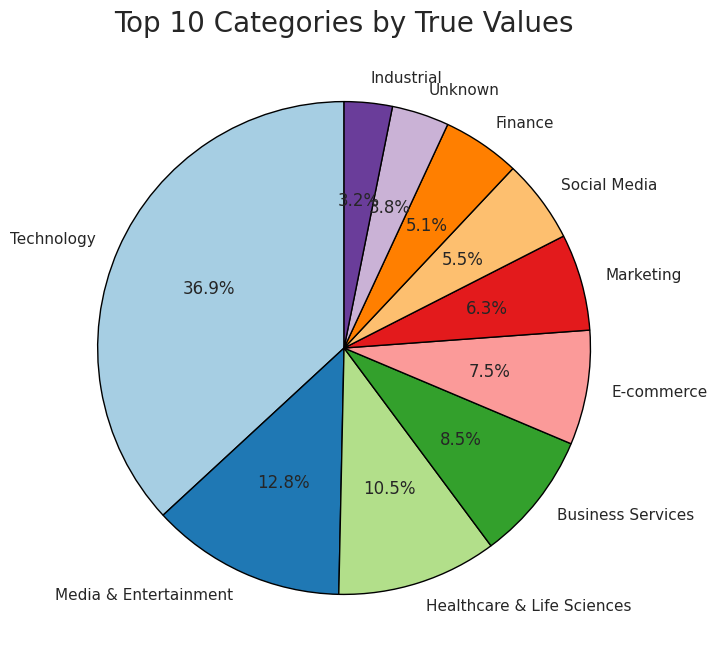

In [47]:
  plot_pie_chart_top_10(startups_train_cons_cat, category_columns)

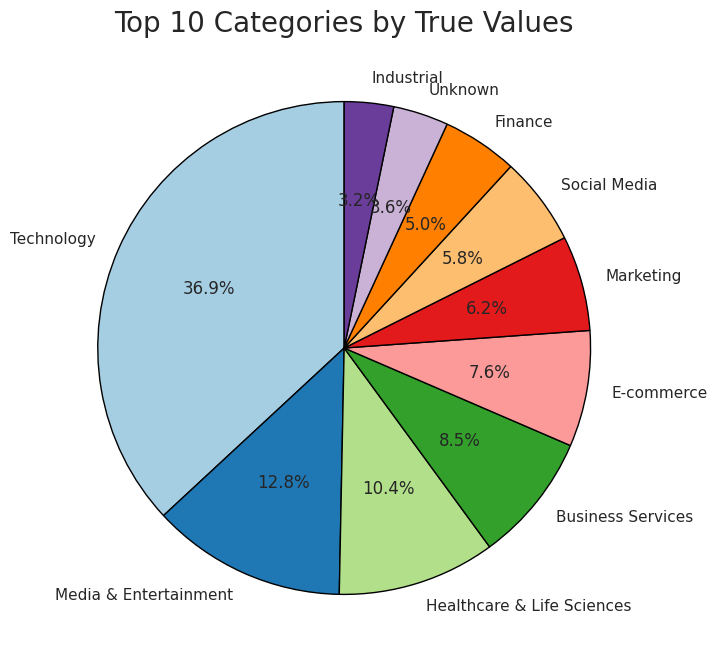

In [48]:
 plot_pie_chart_top_10(startups_test_cons_cat, category_columns)

### Выводы


## Обучение и проверка модели

### Подготовка данных

In [49]:
# Определяем целевую переменную и признаки
X = startups_train_cons_cat.drop(columns=['status'])
y = startups_train_cons_cat['status'].cat.codes  # Преобразуем категориальные значения в числовые

In [50]:
# Определяем числовые и категориальные столбцы
# numeric_features = ['funding_total_usd', 'funding_rounds', 'first_funding_at_year', 'first_funding_at_month', 
# 'last_funding_at_year', 'last_funding_at_month', 'lifetime']
# categorical_features = ['country_code', 'state_code', 'region', 'city']

numeric_features = ['funding_total_usd', 'funding_rounds', 'first_funding_at_year', 'last_funding_at_year', 'lifetime']
categorical_features = ['country_code', 'city']

# numeric_features = ['funding_total_usd', 'funding_rounds', 'first_funding_at_year', 'lifetime']
# categorical_features = ['country_code', 'city']

In [51]:
# Определяем шаги для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [52]:
# Создаем трансформер для предобработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [53]:
# Определим SelectKBest для отбора признаков
selector = SelectKBest(score_func=f_classif)

In [54]:
# Создаем пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', RandomForestClassifier())])

In [55]:
# Гиперпараметры для различных моделей
param_distributions = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': randint(10, 100),
        'classifier__max_depth': randint(3, 10),
        'selector__k': randint(5, len(X.columns))
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': randint(1, 15),
        'classifier__weights': ['uniform', 'distance'],
        'selector__k': randint(5, len(X.columns))
    },
    {
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': uniform(0.1, 10),
        'classifier__penalty': ['l2'],
        'selector__k': randint(5, len(X.columns))
    },
    {
        'classifier': [SVC()],
        'classifier__C': uniform(0.1, 10),
        'classifier__kernel': ['linear', 'rbf'],
        'selector__k': randint(5, len(X.columns))
    }
]

In [56]:
# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Создаем метрику F1 для класса 'operating'
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)  # pos_label=1 означает, что класс 'operating' является положительным

In [58]:
# RandomizedSearchCV для поиска лучших гиперпараметров
# random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=20, scoring=f1_scorer, cv=5, random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions, 
    n_iter=20, 
    scoring=f1_scorer, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
    random_state=42, 
    n_jobs=-1
)

In [59]:
# Обучаем модель
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['funding_total_usd',
                                                                                'funding_rounds',
                                                                                'first_funding_at_year',
                                                                                'last_funding_at_year',
                                                                                'lifetime']),
                                                                              (...
                                         'selector__k': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1db037abc0>},
                                        {'classifier': [SVC(C=8.424426408004217)],
                                         'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f1db03795d0>,
                                         'classifier__kernel': ['linear',
                                                                'rbf'],
                                         'selector__k': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1db05ed810>}],
                   random_state=42,
                   scoring=make_scorer(f1_score, average=binary, pos_label=1))

In [60]:
# Прогнозируем на тестовом наборе
y_pred = random_search.predict(X_test)

In [61]:
# Оцениваем результаты
print("Best parameters found: ", random_search.best_params_)
print("F1 score: ", f1_score(y_test, y_pred, average='binary', pos_label=1))
print(classification_report(y_test, y_pred, target_names=['operating', 'close']))

Best parameters found:  {'classifier': SVC(C=8.424426408004217), 'classifier__C': 8.424426408004217, 'classifier__kernel': 'rbf', 'selector__k': 6}
F1 score:  0.8716814159292036
              precision    recall  f1-score   support

   operating       0.98      1.00      0.99      9521
       close       0.96      0.80      0.87       983

    accuracy                           0.98     10504
   macro avg       0.97      0.90      0.93     10504
weighted avg       0.98      0.98      0.98     10504



In [62]:
# Применяю лучшую модель к тестовой выборке
new_test_data = startups_test_cons_cat.copy()

In [63]:
# Извлекаем индекс в колонку 'name'
new_test_data = new_test_data.reset_index()

# Применяем лучшую модель к новому тестовому набору данных
best_model = random_search.best_estimator_

# Прогнозируем метки для нового тестового набора
new_predictions = best_model.predict(new_test_data.drop(columns=['name']))

# Преобразуем прогнозы в категории 'closed' и 'operating'
new_test_data['status'] = pd.Categorical.from_codes(new_predictions, categories=['closed', 'operating'])

# Создаем финальный DataFrame для сабмита в формате Kaggle
submission_df = new_test_data[['name', 'status']]

# Выводим несколько строк, чтобы проверить формат
print(submission_df.head())

# Сохраняем результат в CSV файл для сабмита
submission_df.to_csv('kaggle_startups_submit.csv', index=False)

# Если нужно просто показать DataFrame пользователю:
submission_df.head()

                     name  status
0              Crystalsol  closed
1        JBI Fish & Wings  closed
2                COINPLUS  closed
3  Imagine Communications  closed
4                   DNA13  closed


name  status
0              Crystalsol  closed
1        JBI Fish & Wings  closed
2                COINPLUS  closed
3  Imagine Communications  closed
4                   DNA13  closed

In [64]:
submission_df.shape

(13125, 2)

In [65]:
startups_test_cons_cat.shape

(13125, 48)